# Fetch and process
> This notebook fetches and processes trees from a data set I've toyed with for years, collecting 1.6 million [records](https://docs.google.com/spreadsheets/d/1TP360PFXrhldG5Gnpfq_YrDoNDK-P6J7HUC5FT8DPJU/edit?pli=1#gid=507390167) from roughly 40 municipalities in Los Angeles County through a combination of public data repos and [open-records requests](https://docs.google.com/spreadsheets/d/1TP360PFXrhldG5Gnpfq_YrDoNDK-P6J7HUC5FT8DPJU/edit?pli=1#gid=524264714). Someday I'll endeavor to collect it again in a more documented way.

---

#### Load Python tools and Jupyter config

In [1]:
import os
import pandas as pd
import jupyter_black
import pyarrow as pa
import geopandas as gpd
import contextily as cx
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [2]:
jupyter_black.load()
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
profile_name = os.environ.get("AWS_PERSONAL_PROFILE")

In [3]:
today = pd.Timestamp.today().strftime("%Y-%m-%d")

---

## Fetch
> This is an aggregated file from this directory: `data/municipalities`

In [4]:
src = (
    pd.read_csv("../data/raw/all_lacounty_trees.csv")
    .drop(["wkb_geometry", "oldspecies"], axis=1)
    .reset_index()
    .rename(columns={"index": "id"})
)

In [5]:
src.head()

,id,place,ispalm,mexfanpalm,longitude,latitude,species,jacaranda,pine,oak,magnolia,category,camphor,ash,crepemyrtle
0,0,santa_clarita,n,n,-118.537267,34.443010,afghan pine,n,y,n,n,pine,n,n,n
1,1,long_beach,n,n,-118.177886,33.830035,vacant,n,n,n,n,other,n,n,n
2,2,pomona,n,n,-117.738320,34.034966,vacant,n,n,n,n,other,n,n,n
3,3,pomona,n,n,-117.739325,34.035233,vacant,n,n,n,n,other,n,n,n
4,4,pomona,n,n,-117.739473,34.035238,vacant,n,n,n,n,other,n,n,n


---

## Process

In [6]:
def convert_yn_to_boolean(df, columns):
    for column in columns:
        df[column] = df[column].map({"y": True, "n": False})
    return df

#### List of columns to convert

In [7]:
columns_to_convert = [
    "ispalm",
    "mexfanpalm",
    "jacaranda",
    "pine",
    "oak",
    "magnolia",
    "camphor",
    "ash",
    "crepemyrtle",
]

#### Convert those columns

In [8]:
src = convert_yn_to_boolean(src, columns_to_convert)

#### Clean up place and species names

In [9]:
src["place"] = src["place"].str.replace("_", " ").str.title()
src["species"] = src["species"].str.replace("_", " ").str.title()

In [10]:
df = src[
    [
        "id",
        "place",
        "species",
        "ispalm",
        "mexfanpalm",
        "jacaranda",
        "pine",
        "oak",
        "magnolia",
        "category",
        "camphor",
        "ash",
        "crepemyrtle",
        "longitude",
        "latitude",
    ]
].copy()

---

## Analyze

#### How many trees?

In [11]:
len(df)

1603004

#### How many trees without a species specified? 

In [12]:
len(df.query("species == 'Vacant'"))

216742

#### How many distinct species?

In [13]:
len(df.query("species != 'Vacant'")["species"].str.strip().unique())

1387

#### Random five trees

In [14]:
df.sample(5)

,id,place,species,ispalm,mexfanpalm,jacaranda,pine,oak,magnolia,category,camphor,ash,crepemyrtle,longitude,latitude
35328,35328,Beverly Hills,Vacant,False,False,False,False,False,False,other,False,False,False,-118.397329,34.104607
850255,850255,Duarte,Indian Laurel Fig,False,False,False,False,False,False,other,False,False,False,-117.944831,34.138261
129467,129467,Santa Clarita,Afghan Pine,False,False,False,True,False,False,pine,False,False,False,-118.543898,34.435607
1301530,1301530,Carson,Vacant,False,False,False,False,False,False,other,False,False,False,-118.271636,33.829092
276722,276722,Alhambra,Southern Magnolia,False,False,False,False,False,True,magnolia,False,False,False,-96.001469,40.000289


---

## Aggregate

#### How many trees in each place? 

In [15]:
city_counts = (
    df.groupby("place")["id"]
    .count()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
city_counts.head()

,place,count
19,Los Angeles City,540668
18,Long Beach,140822
33,Santa Clarita,111473
20,Los Angeles County,96053
25,Pasadena,71132


#### Species by city

In [16]:
city_species_counts = (
    df.query('species != "Vacant"')
    .groupby(["place", "species"])["id"]
    .count()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
city_species_counts.head()

,place,species,count
4081,Los Angeles City,Crepe Myrtle,37740
3948,Los Angeles City,American Sweetgum,33627
4244,Los Angeles City,Mexican Fan Palm,25079
4408,Los Angeles City,Southern Magnolia,22838
4249,Los Angeles City,Modesto Ash,14126


#### Jacarandas

In [17]:
city_jacarandas = (
    df.query('species != "Vacant" and jacaranda == True')
    .groupby(["place"])["id"]
    .count()
    .reset_index(name="jacaradas")
    .sort_values("jacaradas", ascending=False)
)
city_jacarandas.head()

,place,jacaradas
19,Los Angeles City,13168
18,Long Beach,6798
20,Los Angeles County,2247
15,Glendale,2031
39,Whittier,1774


#### Function to determine palm tree share of all trees

In [18]:
def calculate_tree_shares(df, place_column, attribute_column):
    """
    Calculate the share of a specific type of tree (indicated by attribute_column)
    out of the total trees, grouped by the specified place column.

    Parameters:
    - df: DataFrame containing the data.
    - place_column: String, name of the column indicating the place (e.g., city, neighborhood).
    - attribute_column: String, name of the boolean column indicating the presence of a specific tree type.

    Returns:
    - DataFrame with columns for place, total trees, count of specified tree type,
      and share of specified tree type, sorted by share in descending order.
    """
    tree_counts = (
        df.groupby(place_column)
        .agg(
            total_trees=pd.NamedAgg(column=attribute_column, aggfunc="count"),
            specific_trees=pd.NamedAgg(column=attribute_column, aggfunc="sum"),
        )
        .reset_index()
    )

    tree_counts["specific_trees"] = tree_counts["specific_trees"].astype(int)

    tree_counts["tree_share"] = (
        (tree_counts["specific_trees"] / tree_counts["total_trees"]) * 100
    ).round(2)

    tree_counts_sorted = tree_counts.sort_values("tree_share", ascending=False)

    return tree_counts_sorted

#### Calculate the share of palm trees

In [19]:
la_county_palm_shares = calculate_tree_shares(df, "place", "ispalm")

#### How many LA trees are palms?

In [20]:
la_county_palm_shares.query('place=="Los Angeles City"').head()

,place,total_trees,specific_trees,tree_share
19,Los Angeles City,540668,41928,7.75


---

## Geography

#### Create a geodataframe

In [21]:
geometry = gpd.points_from_xy(df.longitude, df.latitude)
gdf = (
    gpd.GeoDataFrame(df, geometry=geometry)
    .drop(["longitude", "latitude"], axis=1)
    .set_crs("4326")
)

<Axes: >

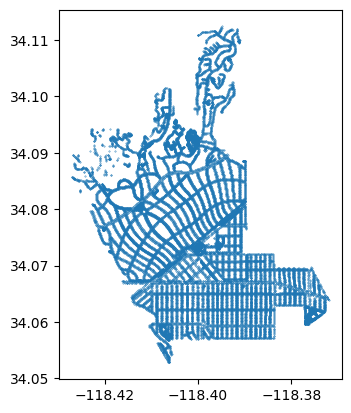

In [22]:
gdf.query('place == "Beverly Hills"').plot(markersize=0.1)

#### LA County cities, unincorporated areas and LA City neighborhoods

In [39]:
import requests
import geopandas as gpd
from io import StringIO

url = "https://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Political_Boundaries/MapServer/19/query"
params = {"outFields": "*", "where": "1=1", "f": "geojson"}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    cities_gdf = gpd.GeoDataFrame.from_features(data["features"])
    cities_gdf.columns = cities_gdf.columns.str.lower()
else:
    print("Failed to fetch data:", response.status_code, response.text)

In [63]:
cities_gdf.query('city_name == "Los Angeles"')[
    [
        "geometry",
        "objectid",
        "city_type",
        "city_name",
        "city_label",
        "abbr",
        # "url",
        # "phone",
        "of_area_sm",
        "feat_type",
        # "color_egis",
        "shape.starea()",
        "shape.stlength()",
        # "last_edited_date",
        # "created_user",
        # "created_date",
        # "last_edited_user",
    ]
]

,geometry,objectid,city_type,city_name,city_label,abbr,of_area_sm,feat_type,shape.starea(),shape.stlength()
1,"POLYGON ((-118.27989 33.75637, -118.27990 33.7...",1535,City,Los Angeles,Los Angeles,LA,468.852,Pier,5.488869e+04,1.788359e+03
27,"POLYGON ((-118.27478 33.74069, -118.27455 33.7...",1564,City,Los Angeles,Los Angeles,LA,468.852,Land,9.121841e+07,1.015325e+05
29,"POLYGON ((-118.45962 33.96368, -118.45740 33.9...",1566,City,Los Angeles,Los Angeles,LA,468.852,Water,1.972737e+06,6.163658e+03
33,"POLYGON ((-118.27857 33.75735, -118.27860 33.7...",1570,City,Los Angeles,Los Angeles,LA,468.852,Pier,3.231881e+04,9.721960e+02
34,"POLYGON ((-118.27742 33.70777, -118.27741 33.7...",1571,City,Los Angeles,Los Angeles,LA,468.852,Breakwater,2.857691e+05,1.739138e+04
79,"POLYGON ((-118.46028 33.96346, -118.46025 33.9...",1618,City,Los Angeles,Los Angeles,LA,468.852,Breakwater,3.027195e+04,1.419491e+03
119,"POLYGON ((-118.27736 33.70813, -118.27727 33.7...",1659,City,Los Angeles,Los Angeles,LA,468.852,Pier,3.355399e+04,2.760132e+03
121,"POLYGON ((-118.28390 33.71346, -118.28388 33.7...",1661,City,Los Angeles,Los Angeles,LA,468.852,Breakwater,1.951510e+03,2.157748e+02
129,"POLYGON ((-118.46421 33.96283, -118.46419 33.9...",1670,City,Los Angeles,Los Angeles,LA,468.852,Breakwater,1.409636e+05,4.932587e+03
130,"POLYGON ((-118.27245 33.72397, -118.27241 33.7...",1671,City,Los Angeles,Los Angeles,LA,468.852,Pier,5.016409e+04,1.634542e+03


#### Just the city of LA

In [42]:
nola_gdf = cities_gdf.query('city_name!="Los Angeles"').dissolve()

<Axes: >

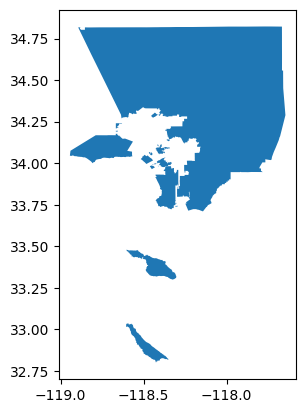

In [43]:
nola_gdf.plot()

In [44]:
nola_gdf

,geometry,objectid,city_type,city_name,city_label,abbr,url,phone,of_area_sm,feat_type,color_egis,shape.starea(),shape.stlength(),last_edited_date,created_user,created_date,last_edited_user
0,"MULTIPOLYGON (((-118.47410 32.83856, -118.4741...",1534,City,Long Beach,Long Beach,LB,www.longbeach.gov,5625706555,50.309,Pier,"Purple - RGB 185,185,250",7413.660018,617.132102,1712048209000,DPW,1712048209000,DPW


#### LA city neighborhoods

In [33]:
url = "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query"
params = {"outFields": "*", "where": "1=1", "f": "geojson"}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    lahoods_gdf = (
        gpd.GeoDataFrame.from_features(data["features"])
        .rename(columns={"OBJECTID": "id"})
        .set_crs("epsg:4326")
    )
    lahoods_gdf.columns = lahoods_gdf.columns.str.lower()
else:
    print("Failed to fetch data:", response.status_code, response.text)

In [34]:
lahoods_gdf.head()

,geometry,id,name
0,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",1,Adams-Normandie
1,"POLYGON ((-118.44255 34.26412, -118.44240 34.2...",2,Arleta
2,"POLYGON ((-118.31862 34.05306, -118.31673 34.0...",3,Arlington Heights
3,"MULTIPOLYGON (((-118.27886 34.15321, -118.2788...",4,Atwater Village
4,"POLYGON ((-118.36102 34.02532, -118.36026 34.0...",5,Baldwin Hills/Crenshaw


#### Merge LA Counties cities with neighborhood boundaries in LA

In [ ]:
lahoods_merge = (
    gpd.sjoin(gdf, lahoods_gdf[["name", "geometry"]], predicate="within")
    .drop(["index_right", "id"], axis=1)
    .rename(columns={"name": "neighborhood"})
).reset_index(drop=True)

#### Palms in LA by neighborhood? 

In [ ]:
la_city_palm_shares = calculate_tree_shares(lahoods_merge, "neighborhood", "ispalm")

In [ ]:
la_city_palm_shares.head()

#### Jacarandas in LA by neighborhood? 

In [ ]:
la_city_jacaranda_shares = calculate_tree_shares(
    lahoods_merge, "neighborhood", "jacaranda"
)

In [ ]:
la_city_jacaranda_shares.head()

#### Magnolias in LA by neighborhood? 

In [ ]:
la_city_magnolia_shares = calculate_tree_shares(
    lahoods_merge, "neighborhood", "magnolia"
)

In [ ]:
la_city_magnolia_shares.head()

## Visuals

#### Plot LA city trees over CartoDB base

In [ ]:
gdf_la = gdf[gdf["place"] == "Los Angeles City"]

In [ ]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the palm tree locations
gdf_la.plot(ax=ax, color="#95cc89", markersize=0.05)

# Add a basemap. The crs parameter is important for aligning the data with the basemap
cx.add_basemap(ax, crs=gdf_la.crs.to_string(), source=cx.providers.CartoDB.Positron)

# Set the axis to equal aspect ratio
ax.set_aspect("equal")

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])

# Remove the border
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

#### Palm trees in LA?

In [ ]:
gdf_palm = gdf_la.query("ispalm == True")
gdf_non_palm = gdf_la.query("ispalm == False")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_non_palm.plot(ax=ax, color="#95cc89", markersize=0.1, label="Other trees")
gdf_palm.plot(ax=ax, color="#396c2e", markersize=0.1, label="Palm trees")

cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])

ax.legend()

for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

---

## Exports

#### JSON

In [ ]:
# df.to_json(
#     "../data/processed/la_county_tree_locations.json", indent=4, orient="records"
# )

#### CSV

In [ ]:
# df.to_csv("../data/processed/la_county_tree_locations.csv", index=False)

#### GeoJSON

In [ ]:
# gdf.to_file(
#     "../data/processed/la_tree_locations_locations.geojson",
#     driver="GeoJSON",
# )

#### Parquet

In [ ]:
# df_p = df.copy()
# table = pa.Table.from_pandas(df_p)
# pq.write_table(table, "../data/small/la_county_tree_locations.parquet")

#### Store on s3
> Download: https://stiles-data.s3.us-west-1.amazonaws.com/trees/{file_name_here.filetype}

In [ ]:
# !aws s3 cp ../data/processed/la_county_tree_locations.json s3://stiles-data/trees/la_county_tree_locations.json --profile {profile_name}

In [ ]:
# !aws s3 cp ../data/processed/la_county_tree_locations.csv s3://stiles-data/trees/la_county_tree_locations.csv --profile {profile_name}

In [ ]:
# !aws s3 cp ../data/processed/la_tree_locations_locations.geojson s3://stiles-data/trees/la_county_tree_locations.geojson --profile {profile_name}

In [ ]:
# !aws s3 cp ../data/small/la_county_tree_locations.parquet s3://stiles-data/trees/la_county_tree_locations.parquet --profile {profile_name}